***STEP1: WE ARE IMPLEMENTING YOLO IN KERAS TO TRY TO UNDERSTAND WHAT WE ARE DOING***

Because our business case is quite unique, we might not need all the layers that the original yolo model offers

In [1]:
#Let's first load all the libraries we need

from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
#import imgaug as ia
from tqdm import tqdm
#from imgaug import augmenters as iaa
import numpy as np
import pandas as pd
import pickle
import os, cv2
#from preprocessing import parse_annotation, BatchGenerator


/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#custom to us are the labels and the image size
LABELS = ['melanoma', 'notmelanoma']

    #I originally tried 200 * 200 and gave me an error - this is because the input layer is a 32 neuron so we need multiples of 32
#I'm going to use 32*7 = 224

IMAGE_H, IMAGE_W = 192, 192
#Grids are used when you are facing problems with more than one object to detect and the fact they alow 2 (in the original)
#overlapping bouding boxes. In our case, we have only 1 very well defined object to detect so we don't need more than 1 grid 

#GRID_H,  GRID_W  = 7 , 7

#Let's leave the rest as is

BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

***STEP 1.1: LET'S BUILD THE NETWORK***

In [3]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [5]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
#true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

#NOTE ON THE SINTAX = This isn't using Sequential(), it's building a pipeline of layers applied to
#the input_image. So what this is doing x = fn...(f1(x)). Nested functions. This is very useful when you need to do skip
#connections or you need to do something a bit more complex to the output, it isn't a clear sequence

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)
# As per the comment below, we only need 4 outputs so we are adding a dense layer as an output with one neuron per dimension
#Important - the output of layer22 is a 6*6 feature map with 1024 feature maps so 6*6*1024 - This is not really what we need
#Therefore we need to flatten the output so we can apply the final transforamtion in the dense and get the output we nee
#output.shape(none, 4) 
#none = the number of batches if we were splitting our dataset in batches


x = Flatten()(x)
x = Dropout(0.5)(x)
#We are now adding classification so you need two different activation functions - one linear for the bounding box
# and a sigmoid for the classification problem
output_box = Dense(4, activation='linear', name='output_box')(x)
output_class = Dense(1, activation ='sigmoid', name='output_class')(x)

output = [output_box, output_class]



# Layer 23
#What they are doing here is to recreante a dense layer using a convolusion but they are just fixing the weights for each feature
#map but reading each pixel at a time with those same weights in each feature map
#What we want is to adapt this layer to the number of outputs we want. In our case - xmin, ymin, xmax, ymax

#x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
#output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
#output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model(input_image, output)

***Freeze layers***

Freezing layers - this are needed because when we printed the original summary we have 50million+ trainable parameters and even if we have prelearnt weights, it will optimise them again

Total params: 50,695,396
Trainable params: 50,674,724
Non-trainable params: 20,672


In [ ]:
#for i in range(1,23):
    #model.layers[i].trainable = False


In [ ]:
model.summary()

***STEP 2: Load the YOLO pre-learnt weights***

In [6]:
from utils import WeightReader, decode_netout, draw_boxes
wt_path = "/home/martar/notebooks/Unipart Project/Final Project/YOLO/weights/yolov3.weights"
weight_reader = WeightReader(wt_path)
weight_reader

In [7]:
#This is doing the weight initialisation from random to the weights that have already being learnt by the YOLO model we are implementing

weight_reader.reset()

#we need to adjust the nb_conv because we removed the other layer they had and added our own, and because it's our own
#it won't have learnt weight

nb_conv = 22

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    
    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

***STEP 3: GET THE X AND Y IN THE RIGHT FORMAT FOR BOTH TRAIN AND TEST***

In [8]:
#Last step would be to train the model, defining the batchsize and the epochs
#model.fit(X, y, batch_size=32, epochs=26)
train_df = pd.read_csv('/home/martar/notebooks/Unipart Project/Final Project/preprocessed_data/train_labels.csv', index_col="filename")
test_df = pd.read_csv('/home/martar/notebooks/Unipart Project/Final Project/preprocessed_data/test_labels.csv', index_col="filename")


In [9]:
read_path = ['/home/martar/notebooks/Unipart Project/Final Project/melanoma/preprocessed_data/', '/home/martar/notebooks/Unipart Project/Final Project/notmelanoma/preprocessed_data/']

function = lambda x: read_path[1] if 'notmelanoma' in x else read_path[0]
function2 = lambda x: 0 if 'notmelanoma' in x else 1

train_df["readpath"] = train_df["class"].apply(function)
test_df["readpath"] = test_df["class"].apply(function)
train_df["class_log"] = train_df["class"].apply(function2)
test_df["class_log"] = test_df["class"].apply(function2)



del train_df["path_name"]
del test_df["path_name"]

In [10]:
from skimage.io import imread

X = [None]*train_df.shape[0]
y = [None]*train_df.shape[0]
y_class = [None]*train_df.shape[0]

X_test = [None]*test_df.shape[0]
y_test = [None]*test_df.shape[0]
y_class_test = [None]*test_df.shape[0]
#We need to normalised the images that we input into the model

#Since 255 is the maximin pixel value. Rescale 1./255 is to transform every pixel value from range [0,255] -> [0,1]. And the benefits are:

#QUESTION - DOES LIST APPEND PRESERVE THE ORDER?
columns_output = ['xmin_norm', 'ymin_norm', 'box_width', 'box_height']
columns_output2 = ['class_log']

for index,file in enumerate(train_df.index.values):
 
    X[index] = imread(train_df["readpath"][index]+file)/255
    y[index] = train_df[columns_output].loc[file]
    y_class[index] = train_df[columns_output2].loc[file].values[0]

#As neural networks use arrays as inputs
X = np.array(X)
y = np.array(y)
y_class = np.array(y_class)


for index,file in enumerate(test_df.index.values):
 
    X_test[index] = imread(test_df["readpath"][index]+file)/255
    y_test[index] = test_df[columns_output].loc[file]
    y_class_test[index] = test_df[columns_output2].loc[file].values[0]

#As neural networks use arrays as inputs
X_test = np.array(X_test)
y_test = np.array(y_test)
y_class_test = np.array(y_class_test)



In [ ]:
X_test.shape, y_test.shape, y_class_test.shape, y_class.shape, y.shape

***STEP 4:  OPTIMISATION AND LOSS FUNCTION***
    
We've build the network and loaded the weights - we now have to decide:
#1 - Optimisation function
#2 - Loss funtion - we are only predicting bounding boxes so we don't need a complex loss function. It's basically a 
regression like problem so we are using the mean squared error as our loss function
The first iteration was potentially overfitting so we need to continue tunning the parameters until we get a good result on training and validation

In [11]:
#This parameters where originally in the model we took
optimizer = Adam(lr=0.001)

#Try Adam, Adamax with default parameters but the lr

#optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-5, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

loss = {'output_box': 'mse',
        'output_class': 'binary_crossentropy'
       }

metrics = {'output_box': ['mae'],
        'output_class': ['accuracy']
       }


alpha = K.variable(0.7)
beta = K.variable(0.3)


#From looking at the results we might need to give the loss different weights as the classification is slowing down the learning
#loss_weights as a parameter

model.compile(loss=loss,loss_weights=[alpha, beta],
              optimizer=optimizer,
              metrics=metrics)

***STEP 5 FIT THE MODEL***
Here we need to decide the number or epochs and batches. 

Notes on epoch - if you fit the model again, it will fit from the last epoch - so recommendation is to start small and do incrementals

We are having quite a lot of issues with the model overfitting so we need to start doing hyperparameter tunning. To be able to compare the results, we are going to use 

 - Tensoboard and then implement early_stop https://keras.io/callbacks/
 - EarlyStop - Stop training when a monitored quantity has stopped improving.


In [ ]:
#model.fit??

In [12]:
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

#early_stop = EarlyStopping(monitor='val_loss', 
                           #min_delta=0, 
                           #patience=5, 
                           #mode='min', 
                           #verbose=1)


#model.fit(X, y, batch_size=32, epochs=50, validation_data=(X_test,y_test),  callbacks = [early_stop,tensorboard])
true_output = [y, y_class]
true_output_val = [y_test,y_class_test]

model.fit(X, true_output, batch_size=32, epochs=150, validation_data=(X_test,true_output_val))



Train on 1148 samples, validate on 42 samples
Epoch 1/150
1148/1148 [==============================] - 46s 40ms/step - loss: 4.5238 - output_box_loss: 6.0801 - output_class_loss: 0.8925 - output_box_mean_absolute_error: 1.2097 - output_class_acc: 0.5305 - val_loss: 0.6770 - val_output_box_loss: 0.6060 - val_output_class_loss: 0.8427 - val_output_box_mean_absolute_error: 0.5674 - val_output_class_acc: 0.4286
Epoch 2/150
1148/1148 [==============================] - 16s 14ms/step - loss: 0.2839 - output_box_loss: 0.1270 - output_class_loss: 0.6500 - output_box_mean_absolute_error: 0.2810 - output_class_acc: 0.6315 - val_loss: 2.6750 - val_output_box_loss: 3.2895 - val_output_class_loss: 1.2413 - val_output_box_mean_absolute_error: 1.3132 - val_output_class_acc: 0.6190
Epoch 3/150
1148/1148 [==============================] - 16s 14ms/step - loss: 0.2237 - output_box_loss: 0.0907 - output_class_loss: 0.5340 - output_box_mean_absolute_error: 0.2407 - output_class_acc: 0.7326 - val_loss: 0.43

1148/1148 [==============================] - 16s 14ms/step - loss: 0.0630 - output_box_loss: 0.0273 - output_class_loss: 0.1461 - output_box_mean_absolute_error: 0.1272 - output_class_acc: 0.9434 - val_loss: 0.2634 - val_output_box_loss: 0.0261 - val_output_class_loss: 0.8169 - val_output_box_mean_absolute_error: 0.1242 - val_output_class_acc: 0.8095
Epoch 24/150
1148/1148 [==============================] - 16s 14ms/step - loss: 0.0567 - output_box_loss: 0.0241 - output_class_loss: 0.1329 - output_box_mean_absolute_error: 0.1189 - output_class_acc: 0.9521 - val_loss: 0.1908 - val_output_box_loss: 0.0115 - val_output_class_loss: 0.6090 - val_output_box_mean_absolute_error: 0.0889 - val_output_class_acc: 0.8095
Epoch 25/150
1148/1148 [==============================] - 16s 14ms/step - loss: 0.0520 - output_box_loss: 0.0233 - output_class_loss: 0.1190 - output_box_mean_absolute_error: 0.1162 - output_class_acc: 0.9530 - val_loss: 0.4579 - val_output_box_loss: 0.0188 - val_output_class_loss

1148/1148 [==============================] - 16s 14ms/step - loss: 0.0242 - output_box_loss: 0.0182 - output_class_loss: 0.0382 - output_box_mean_absolute_error: 0.1038 - output_class_acc: 0.9895 - val_loss: 0.4013 - val_output_box_loss: 0.0309 - val_output_class_loss: 1.2658 - val_output_box_mean_absolute_error: 0.1381 - val_output_class_acc: 0.7619
Epoch 46/150
1148/1148 [==============================] - 16s 14ms/step - loss: 0.0302 - output_box_loss: 0.0176 - output_class_loss: 0.0594 - output_box_mean_absolute_error: 0.1010 - output_class_acc: 0.9808 - val_loss: 0.2674 - val_output_box_loss: 0.0141 - val_output_class_loss: 0.8584 - val_output_box_mean_absolute_error: 0.0935 - val_output_class_acc: 0.8095
Epoch 47/150
1148/1148 [==============================] - 16s 14ms/step - loss: 0.0282 - output_box_loss: 0.0185 - output_class_loss: 0.0508 - output_box_mean_absolute_error: 0.1029 - output_class_acc: 0.9852 - val_loss: 0.3082 - val_output_box_loss: 0.0182 - val_output_class_loss

1148/1148 [==============================] - 16s 14ms/step - loss: 0.0136 - output_box_loss: 0.0135 - output_class_loss: 0.0140 - output_box_mean_absolute_error: 0.0879 - output_class_acc: 0.9965 - val_loss: 0.6069 - val_output_box_loss: 0.0106 - val_output_class_loss: 1.9983 - val_output_box_mean_absolute_error: 0.0771 - val_output_class_acc: 0.7619
Epoch 68/150
1148/1148 [==============================] - 16s 14ms/step - loss: 0.0187 - output_box_loss: 0.0128 - output_class_loss: 0.0326 - output_box_mean_absolute_error: 0.0851 - output_class_acc: 0.9913 - val_loss: 0.7521 - val_output_box_loss: 0.0202 - val_output_class_loss: 2.4599 - val_output_box_mean_absolute_error: 0.1154 - val_output_class_acc: 0.7619
Epoch 69/150
1148/1148 [==============================] - 16s 14ms/step - loss: 0.0136 - output_box_loss: 0.0145 - output_class_loss: 0.0114 - output_box_mean_absolute_error: 0.0898 - output_class_acc: 0.9974 - val_loss: 0.7417 - val_output_box_loss: 0.0687 - val_output_class_loss

1148/1148 [==============================] - 16s 14ms/step - loss: 0.0095 - output_box_loss: 0.0103 - output_class_loss: 0.0078 - output_box_mean_absolute_error: 0.0770 - output_class_acc: 0.9965 - val_loss: 0.3704 - val_output_box_loss: 0.0086 - val_output_class_loss: 1.2148 - val_output_box_mean_absolute_error: 0.0719 - val_output_class_acc: 0.8095
Epoch 90/150
1148/1148 [==============================] - 16s 14ms/step - loss: 0.0367 - output_box_loss: 0.0157 - output_class_loss: 0.0856 - output_box_mean_absolute_error: 0.0942 - output_class_acc: 0.9765 - val_loss: 0.9124 - val_output_box_loss: 0.2396 - val_output_class_loss: 2.4821 - val_output_box_mean_absolute_error: 0.3784 - val_output_class_acc: 0.7143
Epoch 91/150
1148/1148 [==============================] - 16s 14ms/step - loss: 0.0275 - output_box_loss: 0.0192 - output_class_loss: 0.0470 - output_box_mean_absolute_error: 0.1064 - output_class_acc: 0.9817 - val_loss: 0.3736 - val_output_box_loss: 0.0846 - val_output_class_loss

1148/1148 [==============================] - 16s 14ms/step - loss: 0.0072 - output_box_loss: 0.0085 - output_class_loss: 0.0041 - output_box_mean_absolute_error: 0.0710 - output_class_acc: 0.9983 - val_loss: 0.4123 - val_output_box_loss: 0.0120 - val_output_class_loss: 1.3465 - val_output_box_mean_absolute_error: 0.0793 - val_output_class_acc: 0.7857
Epoch 112/150
1148/1148 [==============================] - 16s 14ms/step - loss: 0.0065 - output_box_loss: 0.0085 - output_class_loss: 0.0019 - output_box_mean_absolute_error: 0.0702 - output_class_acc: 1.0000 - val_loss: 0.4200 - val_output_box_loss: 0.0104 - val_output_class_loss: 1.3756 - val_output_box_mean_absolute_error: 0.0704 - val_output_class_acc: 0.7619
Epoch 113/150
1148/1148 [==============================] - 16s 14ms/step - loss: 0.0063 - output_box_loss: 0.0078 - output_class_loss: 0.0030 - output_box_mean_absolute_error: 0.0675 - output_class_acc: 0.9991 - val_loss: 0.5108 - val_output_box_loss: 0.0092 - val_output_class_lo

1148/1148 [==============================] - 16s 14ms/step - loss: 0.0148 - output_box_loss: 0.0160 - output_class_loss: 0.0118 - output_box_mean_absolute_error: 0.0980 - output_class_acc: 0.9956 - val_loss: 0.4140 - val_output_box_loss: 0.0498 - val_output_class_loss: 1.2637 - val_output_box_mean_absolute_error: 0.1760 - val_output_class_acc: 0.8571
Epoch 134/150
1148/1148 [==============================] - 16s 14ms/step - loss: 0.0095 - output_box_loss: 0.0123 - output_class_loss: 0.0032 - output_box_mean_absolute_error: 0.0850 - output_class_acc: 1.0000 - val_loss: 0.3352 - val_output_box_loss: 0.0314 - val_output_class_loss: 1.0441 - val_output_box_mean_absolute_error: 0.1450 - val_output_class_acc: 0.8571
Epoch 135/150
1148/1148 [==============================] - 16s 14ms/step - loss: 0.0082 - output_box_loss: 0.0109 - output_class_loss: 0.0019 - output_box_mean_absolute_error: 0.0810 - output_class_acc: 1.0000 - val_loss: 0.4831 - val_output_box_loss: 0.0159 - val_output_class_lo

In [30]:
#Now that we've removed the early stopping and gone for 150 epochs, we really need to visualise the history to understand what is happening
#When the model is overfiting and so on.


def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    mae_list = [s for s in history.history.keys() if 'output_box_mean_absolute_error' in s and 'val' not in s]
    val_mae_list = [s for s in history.history.keys() if 'val_output_box_mean_absolute_error' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'output_class_acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'val_output_class_acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss'+l+ '(' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss' +l+ '('+ str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 4)
    plt.legend()
    
    ## MAE
    plt.figure(2)
    for l in mae_list:
        plt.plot(epochs, history.history[l], 'b', label='Training MAE (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_mae_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation MAE (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.ylim(0, 4)
    plt.show()
    
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training Accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation Accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
model.history.params

In [17]:
model.save('adam_l001_class_weight.h5')


TypeError: ('Not JSON Serializable:', <tf.Variable 'Variable:0' shape=() dtype=float32_ref>)

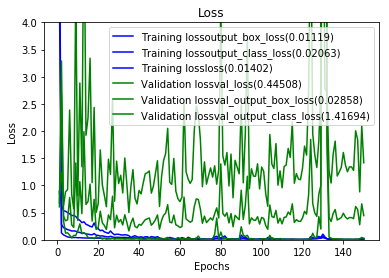

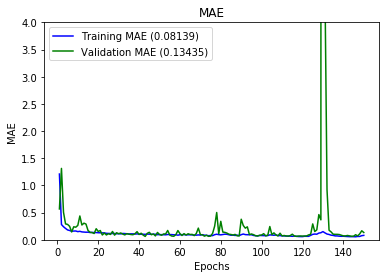

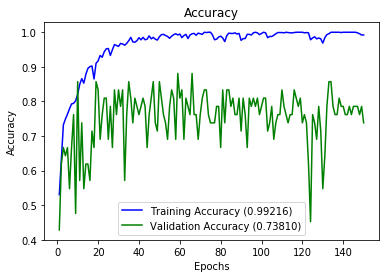

In [31]:
plot_history(model.history)


In [18]:
def plot_example(img, bbox):
    plt.imshow(img)
    plt.plot([bbox[1], bbox[1], bbox[1] + bbox[3], bbox[1] + bbox[3], bbox[1]],
         [bbox[0], bbox[0] + bbox[2], bbox[0] + bbox[2], bbox[0], bbox[0]], 'r')
    plt.axis('off')
    plt.show();

In [19]:
def intersection(a, b):
    x = max(a[0], b[0])
    y = max(a[1], b[1])
    w = min(a[0] + a[2], b[0] + b[2]) - x
    h = min(a[1] + a[3], b[1] + b[3]) - y
    if w < 0 or h < 0:
        return 0
    return w * h

def union(a, b):
    return a[2] * a[3] + b[2] * b[3] - intersection(a, b)

def iou(y_true, y_pred):
    return intersection(y_true, y_pred) / union(y_true, y_pred)

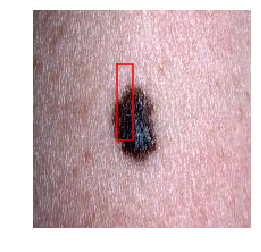

1 [[0.99999917]]


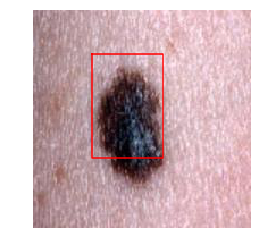

1 [[1.]]


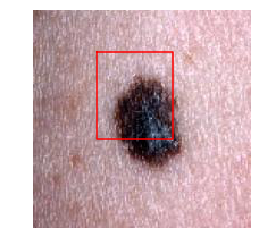

1 [[1.]]


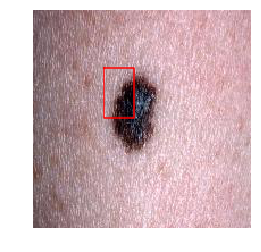

1 [[1.]]


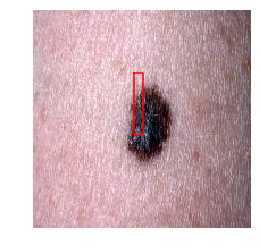

1 [[1.]]


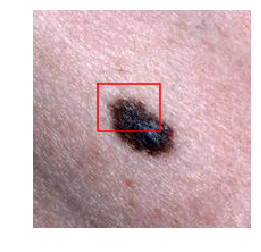

1 [[1.]]


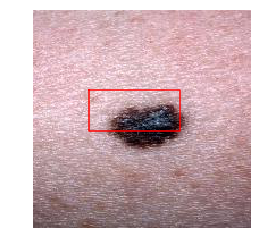

1 [[1.]]


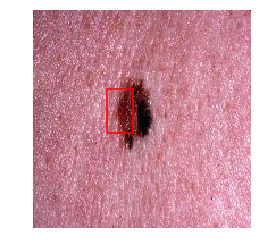

1 [[1.]]


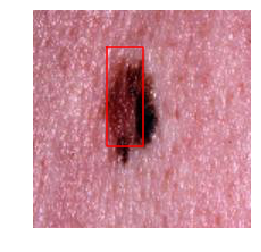

1 [[0.99999976]]


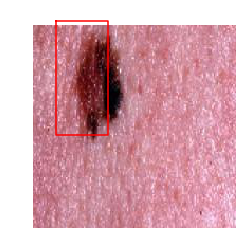

1 [[0.9997733]]


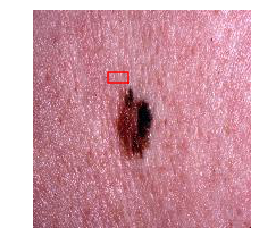

1 [[0.99999917]]


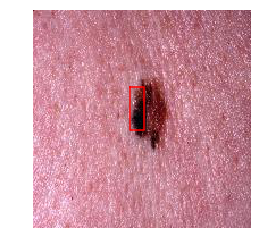

1 [[1.]]


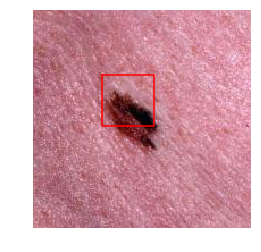

1 [[1.]]


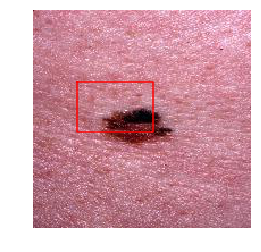

1 [[1.]]


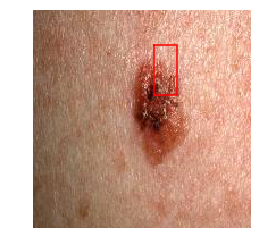

1 [[0.99956733]]


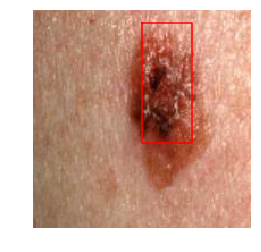

1 [[0.9999926]]


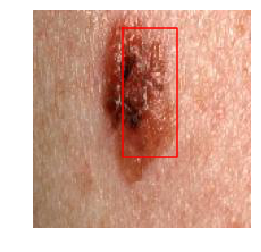

1 [[0.9999989]]


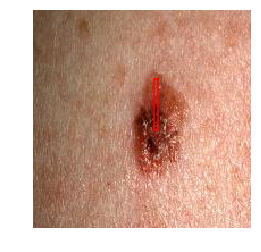

1 [[0.99999046]]


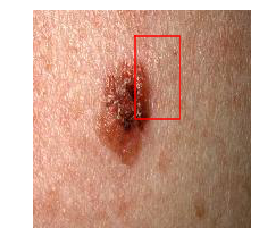

1 [[0.99999976]]


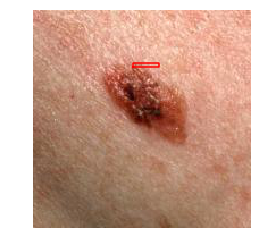

1 [[0.99999845]]


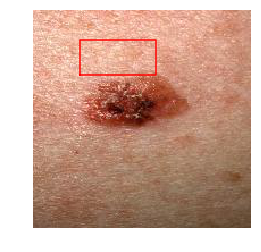

1 [[1.]]


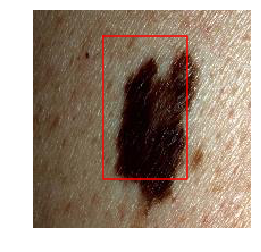

1 [[1.]]


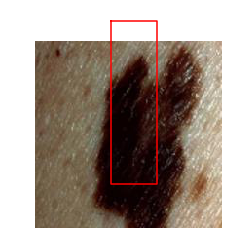

1 [[1.]]


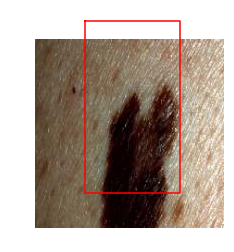

1 [[1.]]


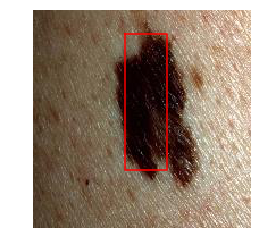

1 [[1.]]


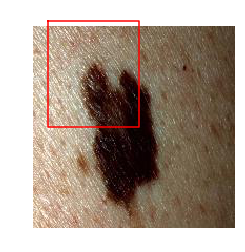

1 [[1.]]


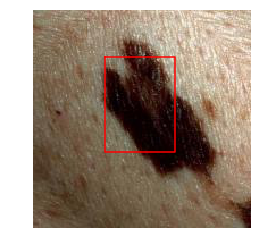

1 [[1.]]


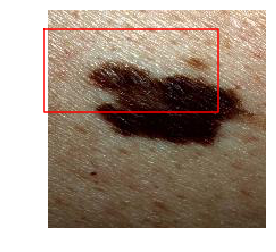

1 [[1.]]


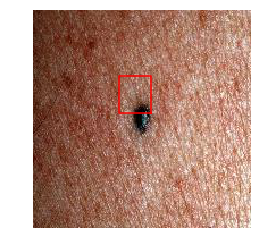

1 [[0.9999957]]


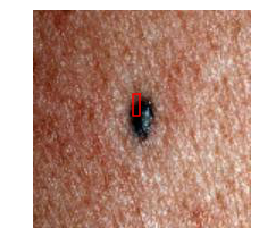

1 [[1.]]


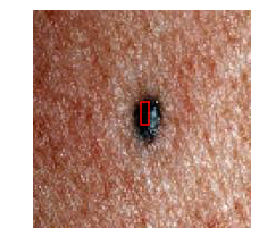

1 [[1.]]


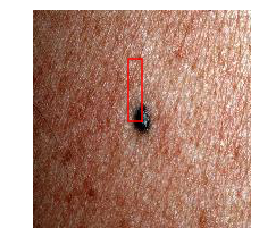

1 [[0.99999285]]


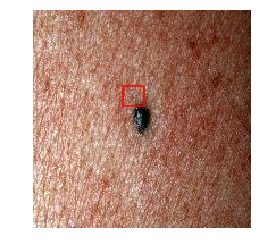

1 [[1.]]


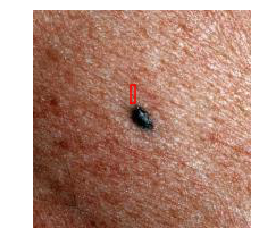

1 [[1.]]


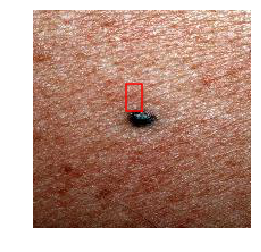

1 [[0.9999976]]


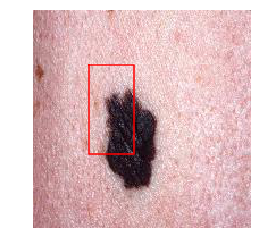

1 [[0.9999994]]


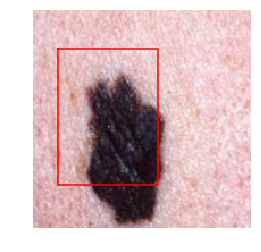

1 [[0.9999994]]


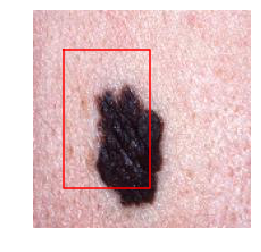

1 [[0.9999243]]


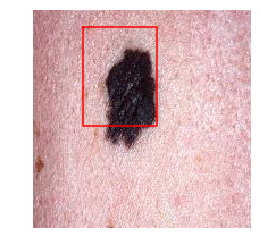

1 [[1.]]


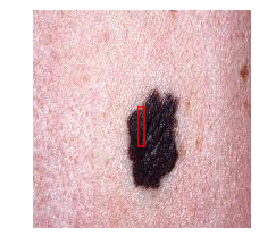

1 [[1.]]


In [20]:
all_iou = np.zeros((np.shape(y)[0],))
for i in range(40): # np.shape(X)[0]): 
    ye = model.predict(X[i:i+1, :, :, :])
    plot_example(X[i,:,:,:], ye[0][0,:]*192)
    all_iou[i] = iou(y[i, :], ye[0][0, :])
    print(y_class[i], ye[1])



In [21]:
for i in range(y.shape[0]):
    ye = model.predict(X[i:i+1, :, :, :])
    all_iou[i] = iou(y[i, :], ye[0][0, :])
print("Our mean iou_training is %s"%all_iou.mean())

Our mean iou_training is 0.17049558006998655


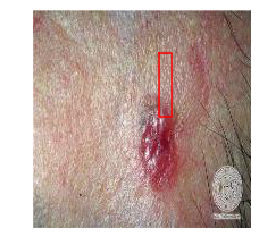

1 [[0.93221104]]


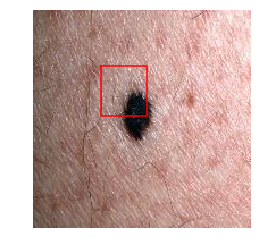

1 [[0.9999832]]


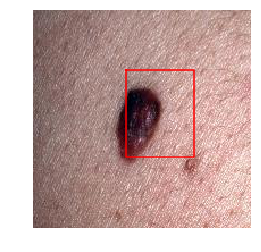

1 [[1.]]


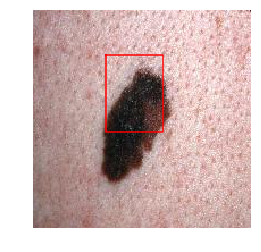

1 [[1.]]


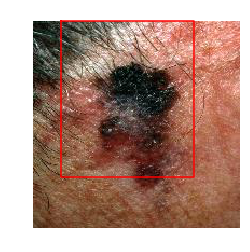

1 [[1.]]


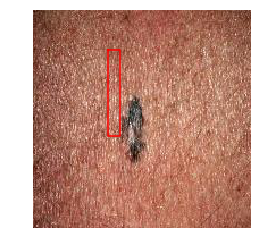

1 [[0.96525407]]


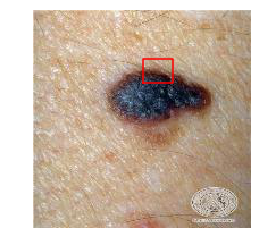

1 [[0.9999995]]


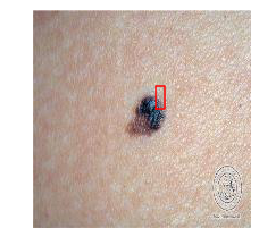

1 [[1.]]


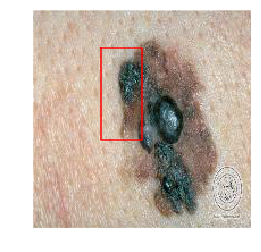

1 [[1.]]


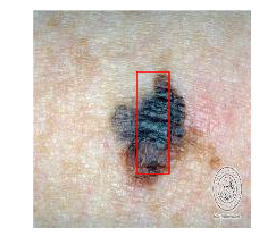

1 [[1.]]


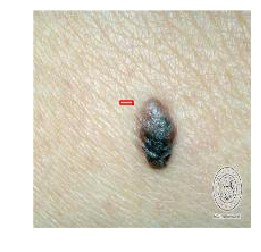

1 [[0.9521932]]


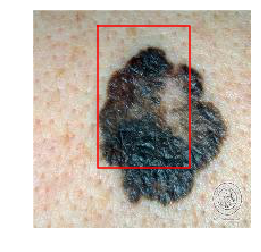

1 [[1.]]


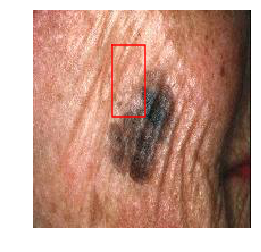

1 [[0.15127245]]


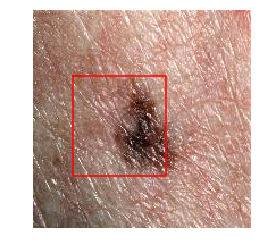

1 [[1.]]


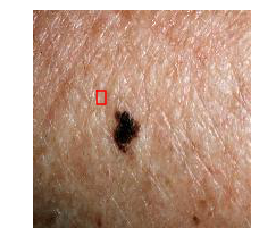

1 [[0.0580007]]


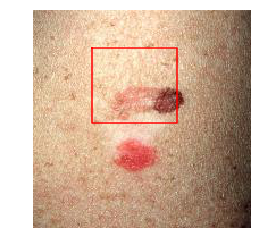

1 [[1.]]


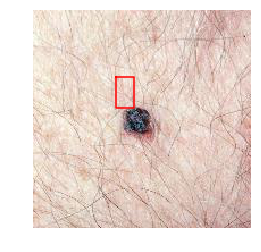

1 [[0.99999857]]


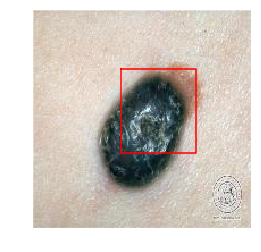

1 [[1.]]


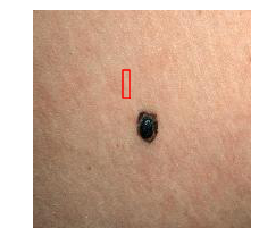

1 [[2.5238267e-05]]


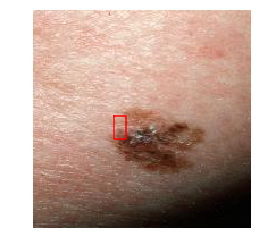

1 [[0.99965966]]


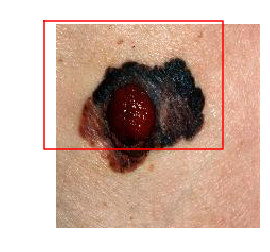

1 [[1.]]


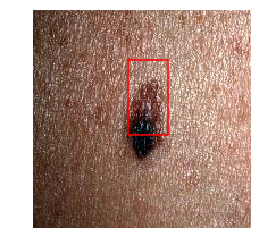

1 [[0.4966444]]


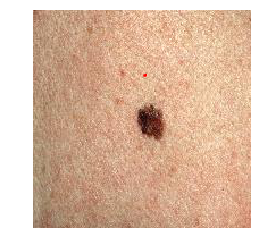

1 [[0.00967799]]


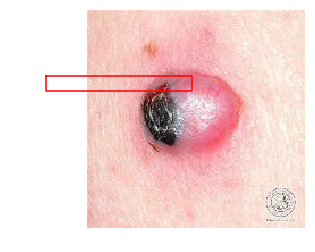

1 [[1.]]


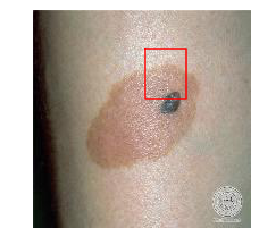

0 [[0.26049992]]


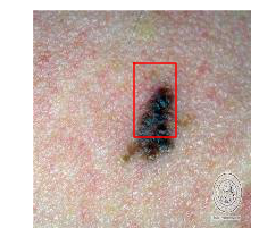

0 [[0.9999969]]


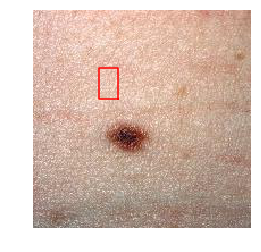

0 [[5.90205e-07]]


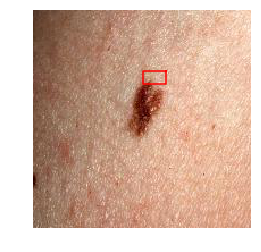

0 [[0.9678871]]


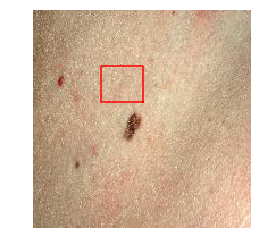

0 [[4.235734e-07]]


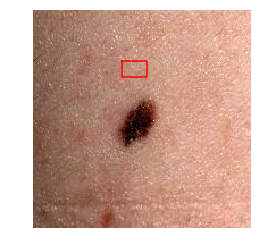

0 [[0.41671923]]


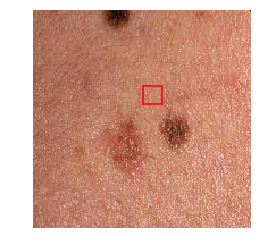

0 [[0.00160893]]


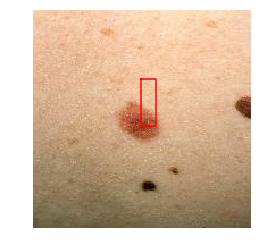

0 [[0.0315708]]


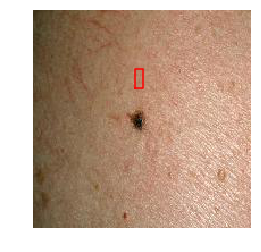

0 [[0.00038101]]


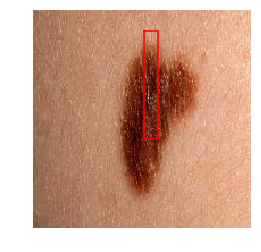

0 [[0.9940299]]


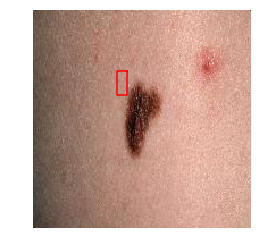

0 [[0.00020355]]


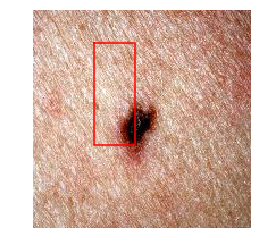

0 [[0.978512]]


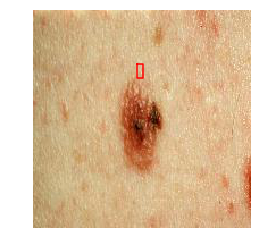

0 [[3.510491e-05]]


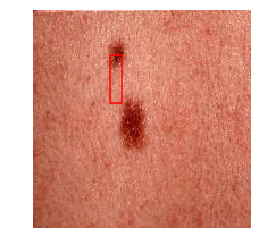

0 [[2.8590602e-08]]


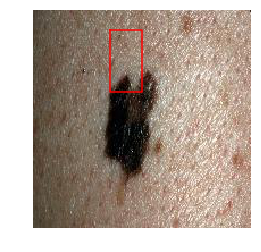

0 [[0.99922657]]


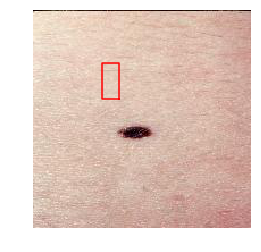

0 [[1.6160482e-05]]


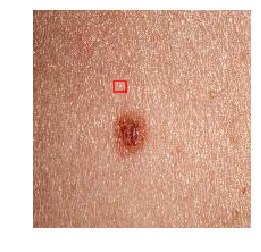

0 [[5.745333e-07]]


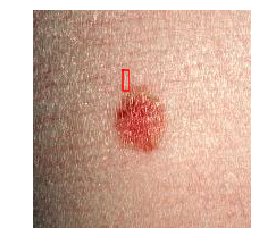

0 [[0.9961959]]
Our mean iou_test is 0.16695383626223478


In [22]:
for i in range(y_test.shape[0]):
    ye_test = model.predict(X_test[i:i+1, :, :, :])
    all_iou[i] = iou(y_test[i, :], ye_test[0][0, :])
    plot_example(X_test[i,:,:,:], ye_test[0][0, :]*192)
    print(y_class_test[i], ye_test[1])
print("Our mean iou_test is %s"%all_iou.mean())
